In [1]:
import os
from os.path import join as pj
os.chdir("/root/workspace/sjh/data/paper")
import argparse
import sys
sys.path.append("modules")
import utils
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
import seaborn as sns
from joblib import Parallel, delayed
import rpy2.robjects as robjects
import umap
import re
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd
import csv
from glob import glob


R[write to console]: Loading required package: SingleCellExperiment

R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: MatrixGenerics

R[write to console]: Loading required package: matrixStats

R[write to console]: 
Attaching package: ‘MatrixGenerics’


R[write to console]: The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowC

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument('--task', type=str, default='imc_ref')
parser.add_argument('--query', type=str, default='imc_query')
parser.add_argument('--experiment', type=str, default='all_2')
parser.add_argument('--model', type=str, default='default')
parser.add_argument('--method', type=str, default='embed')
o, _ = parser.parse_known_args()  # for python interactive
o.init_model = "sp_00000999"


In [3]:
# load reference
cfg_task = re.sub("_vd.*|_vt.*|_atlas|_generalize|_transfer|_ref_.*", "", o.task)
data_config = utils.load_toml("configs/data.toml")[cfg_task]

for k, v in data_config.items():
    vars(o)[k] = v
model_config = utils.load_toml("configs/model.toml")["default"]
if o.model != "default":
    model_config.update(utils.load_toml("configs/model.toml")[o.model])
for k, v in model_config.items():
    vars(o)[k] = v
o.s_joint, o.combs, *_ = utils.gen_all_batch_ids(o.s_joint, o.combs)

o.pred_dir = pj("result", o.task, o.experiment, o.model, "predict", "train", o.init_model)
pred = utils.load_predicted(o)

c_ref = pred["z"]["joint"][:, :o.dim_c]

Loading predicted variables ...
{0: {'z': {'joint': 'result/imc_ref/all_2/default/predict/train/sp_00001499/subset_0/z/joint'}}, 1: {'z': {'joint': 'result/imc_ref/all_2/default/predict/train/sp_00001499/subset_1/z/joint'}}, 2: {'z': {'joint': 'result/imc_ref/all_2/default/predict/train/sp_00001499/subset_2/z/joint'}}, 3: {'z': {'joint': 'result/imc_ref/all_2/default/predict/train/sp_00001499/subset_3/z/joint'}}, 4: {'z': {'joint': 'result/imc_ref/all_2/default/predict/train/sp_00001499/subset_4/z/joint'}}, 5: {'z': {'joint': 'result/imc_ref/all_2/default/predict/train/sp_00001499/subset_5/z/joint'}}, 6: {'z': {'joint': 'result/imc_ref/all_2/default/predict/train/sp_00001499/subset_6/z/joint'}}, 7: {'z': {'joint': 'result/imc_ref/all_2/default/predict/train/sp_00001499/subset_7/z/joint'}}, 8: {'z': {'joint': 'result/imc_ref/all_2/default/predict/train/sp_00001499/subset_8/z/joint'}}, 9: {'z': {'joint': 'result/imc_ref/all_2/default/predict/train/sp_00001499/subset_9/z/joint'}}, 10: {'z

In [4]:
# Load cell type labels
labels = []
batch = []
labels_dir = []
for s in o.s_joint:
    labels_dir += glob(pj("/dev/shm/processed/", o.task, "train", "subset_" + str(s), "labels.csv"))

for l in labels_dir:
    label = utils.load_csv(l)[1:]
    labels += utils.transpose_list(label)[7]
    batch += utils.transpose_list(label)[6]

labels_ref = np.array(labels)
print(list(set(labels_ref)))

['plasma', 'mast_cell', 'dc', 'T', 'non_immune', 'macrophage', 'ILC', 'pDC', 'progenitor', 'Mono', 'B']


In [5]:
cfg_task = re.sub("_vd.*|_vt.*|_atlas|_generalize|_transfer|_ref_.*", "", o.query)
data_config = utils.load_toml("configs/data.toml")[cfg_task]

for k, v in data_config.items():
    vars(o)[k] = v
model_config = utils.load_toml("configs/model.toml")["default"]
if o.model != "default":
    model_config.update(utils.load_toml("configs/model.toml")[o.model])
for k, v in model_config.items():
    vars(o)[k] = v
o.s_joint, o.combs, *_ = utils.gen_all_batch_ids(o.s_joint, o.combs)

o.pred_dir = pj("result", o.task, o.experiment, o.model, "predict", "test", o.init_model)
pred = utils.load_predicted(o)

c_query = pred["z"]["joint"][:, :o.dim_c]

Loading predicted variables ...
{0: {'z': {'joint': 'result/imc_ref/all_2/default/predict/test/sp_00001499/subset_0/z/joint'}}, 1: {'z': {'joint': 'result/imc_ref/all_2/default/predict/test/sp_00001499/subset_1/z/joint'}}}
Converting to numpy ...


In [6]:
# Load cell type labels
labels = []
batch = []
labels_dir = []
for s in o.s_joint:
    labels_dir += glob(pj("/dev/shm/processed/", o.task, "test", "subset_" + str(s), "labels.csv"))

for l in labels_dir:
    label = utils.load_csv(l)[1:]
    labels += utils.transpose_list(label)[2]

labels_query = np.array(labels)
print(list(set(labels_query)))

['plasma', 'mast_cell', 'dc', 'T', 'non_immune', 'macrophage', 'ILC', 'pDC', 'progenitor', 'Mono', 'B']


In [7]:
knn = KNeighborsClassifier(n_neighbors=100, weights='uniform')
knn.fit(c_ref, labels_ref)
label_pred = knn.predict(c_query)

In [8]:
label_query_keys = np.unique(labels_query)
label_pred_keys = np.unique(label_pred)
results = {}
results["confusion"] = confusion_matrix(labels_query, label_pred, labels=label_query_keys)
results["f1"] = f1_score(labels_query, label_pred, average='micro')
print(" f1: ", results["f1"])

 f1:  0.9584525773542978


In [9]:
utils.save_list_to_csv([list(line) for line in list(label_pred.reshape(-1, 1))], "label_transferred.csv")
utils.save_list_to_csv([list(line) for line in list(labels_query.reshape(-1, 1))], "label_gt.csv")

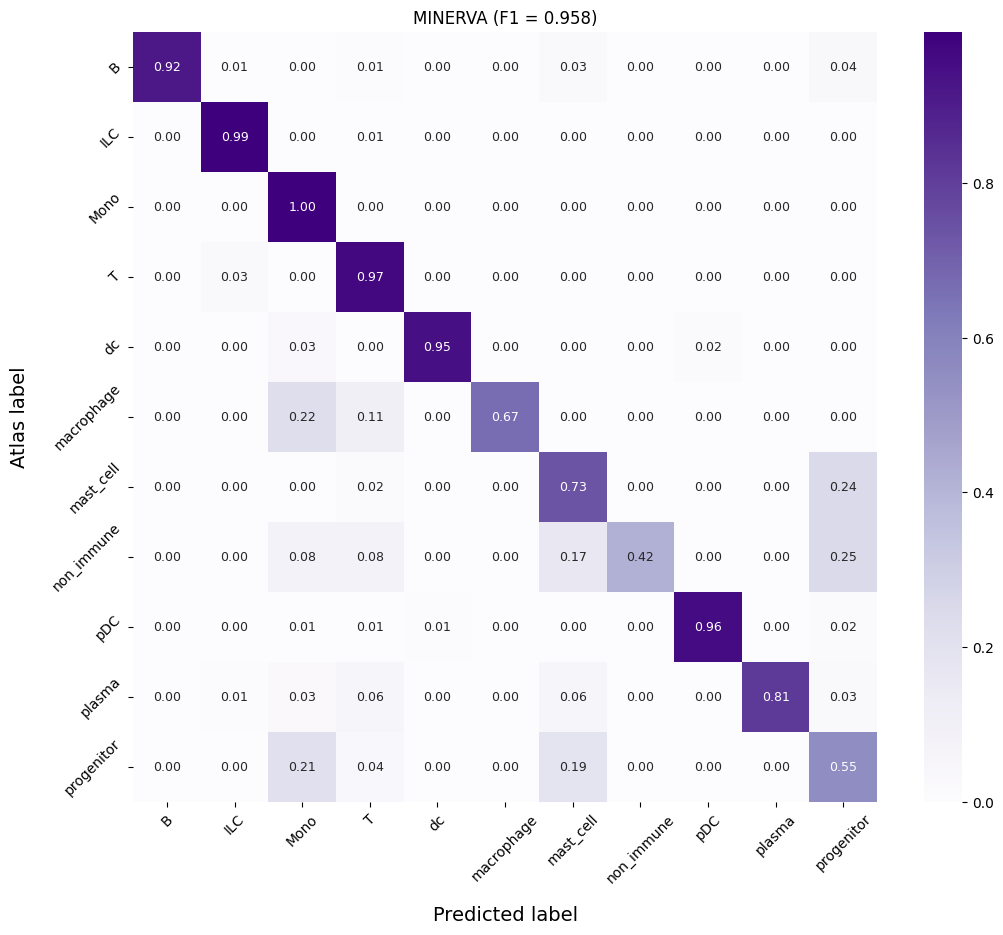

In [32]:
plt.figure(figsize=(12, 10))
cm = results["confusion"].astype('float') / results["confusion"].sum(axis=1)[:, np.newaxis]
ax = sns.heatmap(cm, annot = True, annot_kws={"size": 9}, fmt=".2f", cmap="Purples")
ax.xaxis.set_ticklabels(label_query_keys, rotation=45)
ax.yaxis.set_ticklabels(label_query_keys, rotation=45)

plt.xlabel("Predicted label", labelpad = 15, fontsize = 14)
plt.ylabel("Atlas label", labelpad = 15, fontsize = 14)
plt.title("MINERVA (F1 = 0.958)")

plt.savefig("figure2.svg", bbox_inches = 'tight')